In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as imbPipeline

%matplotlib inline
plt.style.use('fivethirtyeight')

In [78]:
df_values = pd.read_csv('Data/Nepal_Earthquake_train_values.csv', index_col='building_id')
df_labels = pd.read_csv('Data/Nepal_Earthquake_train_labels.csv', index_col='building_id')

### Merge the values dataframe with the labels dataframe

In [79]:
df = df_values.join(df_labels)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

### Target Distribution

In [81]:
df['damage_label'] = df.damage_grade.map(
    {1:'Low Damage', 2:'Medium Damage', 3:'Complete Destruction'})

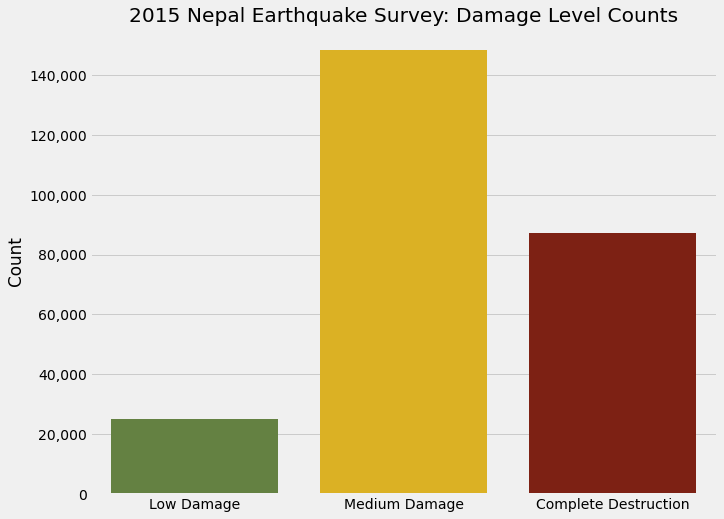

In [82]:
palette = {'Low Damage' : 'xkcd:moss green', 
           'Medium Damage': 'xkcd:goldenrod',
           'Complete Destruction': 'xkcd:brick red'}
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(x='damage_label', data=df, palette=palette, 
                   order=['Low Damage', 'Medium Damage', 'Complete Destruction'])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_title('2015 Nepal Earthquake Survey: Damage Level Counts');

### Create column categories

In [91]:
binary_cols = []
for col in df.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(df.select_dtypes(include='object').columns)
cat_cols.remove('damage_label')

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [93]:
len(all_cols)

38

### Categorical Columns

In [8]:
n_unique = 0
for col in cat_cols:
    n_unique += df[col].nunique()
    print(f"There are {df[col].nunique()} unique values in the feature '{col}'.")
    print(f"The values are {df[col].unique()}")
    print("--------------------------------")
print(f'There are {n_unique} total categorical values in the categorical columns.')

There are 3 unique values in the feature 'land_surface_condition'.
The values are ['t' 'o' 'n']
--------------------------------
There are 5 unique values in the feature 'foundation_type'.
The values are ['r' 'w' 'i' 'u' 'h']
--------------------------------
There are 3 unique values in the feature 'roof_type'.
The values are ['n' 'q' 'x']
--------------------------------
There are 5 unique values in the feature 'ground_floor_type'.
The values are ['f' 'x' 'v' 'z' 'm']
--------------------------------
There are 4 unique values in the feature 'other_floor_type'.
The values are ['q' 'x' 'j' 's']
--------------------------------
There are 4 unique values in the feature 'position'.
The values are ['t' 's' 'j' 'o']
--------------------------------
There are 10 unique values in the feature 'plan_configuration'.
The values are ['d' 'u' 's' 'q' 'm' 'c' 'a' 'n' 'f' 'o']
--------------------------------
There are 4 unique values in the feature 'legal_ownership_status'.
The values are ['v' 'a' 'r

### Binary Columns

<ipython-input-9-21fa6e00ad8f>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(mean_binary_cols.index), rotation=90)


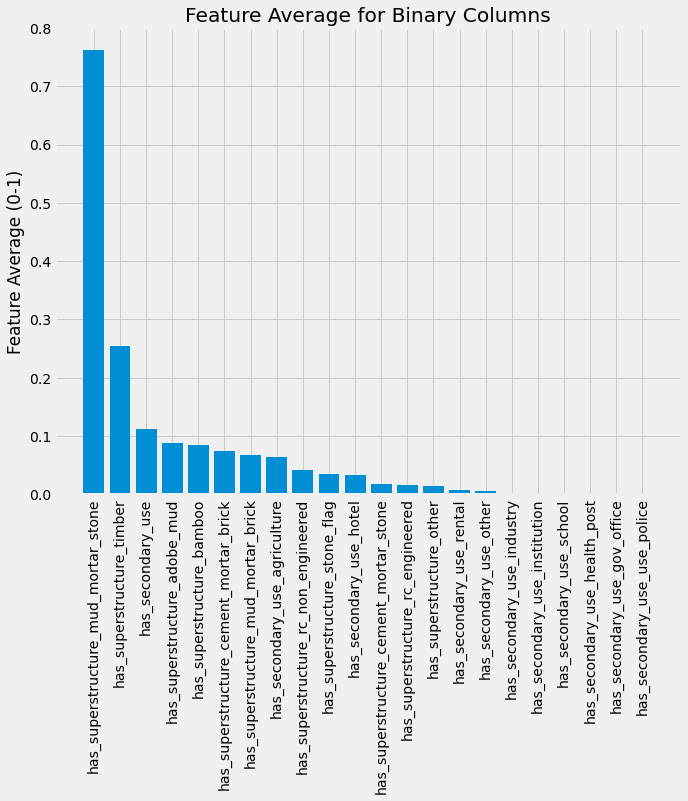

In [9]:
mean_binary_cols = df[binary_cols].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(mean_binary_cols.index, mean_binary_cols.values)
ax.set_xticklabels(list(mean_binary_cols.index), rotation=90)
ax.set_ylabel('Feature Average (0-1)')
ax.set_title('Feature Average for Binary Columns');

### Integer Columns

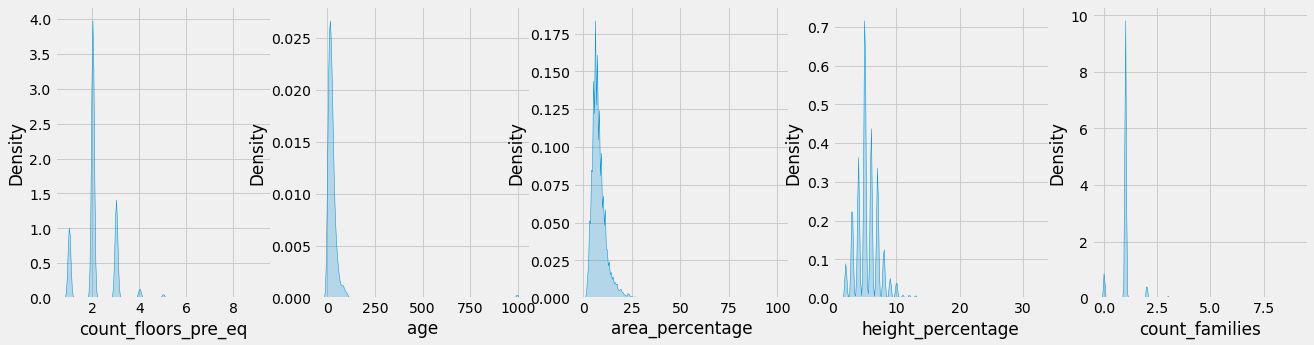

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axs, integer_cols):
    sns.kdeplot(df[col], ax=ax, shade=True);

In [11]:
for col in integer_cols:
    df[f'log_{col}'] = df[col].apply(lambda x: np.log(x+1))
log_cols = []
for col in df.columns:
    if col.startswith('log'):
        log_cols.append(col)

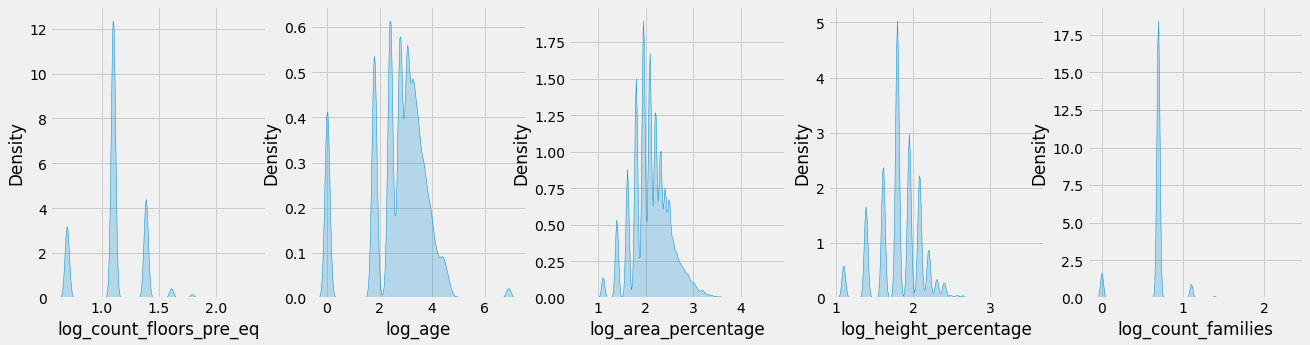

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axs, log_cols):
    sns.kdeplot(df[col], ax=ax, shade=True);

### Geographical Columns

In [13]:
for col in geo_cols:
    print(f'There are {df[col].nunique()} unique values in {col}.')

There are 31 unique values in geo_level_1_id.
There are 1414 unique values in geo_level_2_id.
There are 11595 unique values in geo_level_3_id.


### Correlations

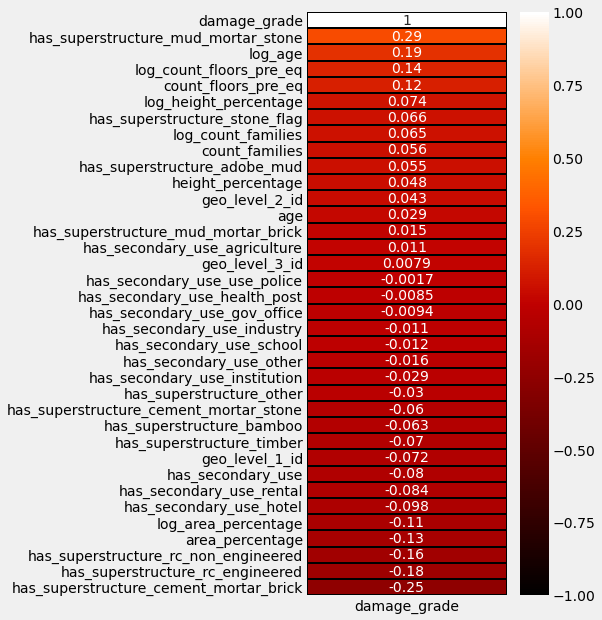

In [14]:
fig, ax = plt.subplots(figsize=(4,10))
sns.heatmap(df.corr()[['damage_grade']].sort_values(by='damage_grade', ascending=False),
           vmin=-1, vmax=1, linewidths=1, linecolor='black', annot=True, cmap="gist_heat");

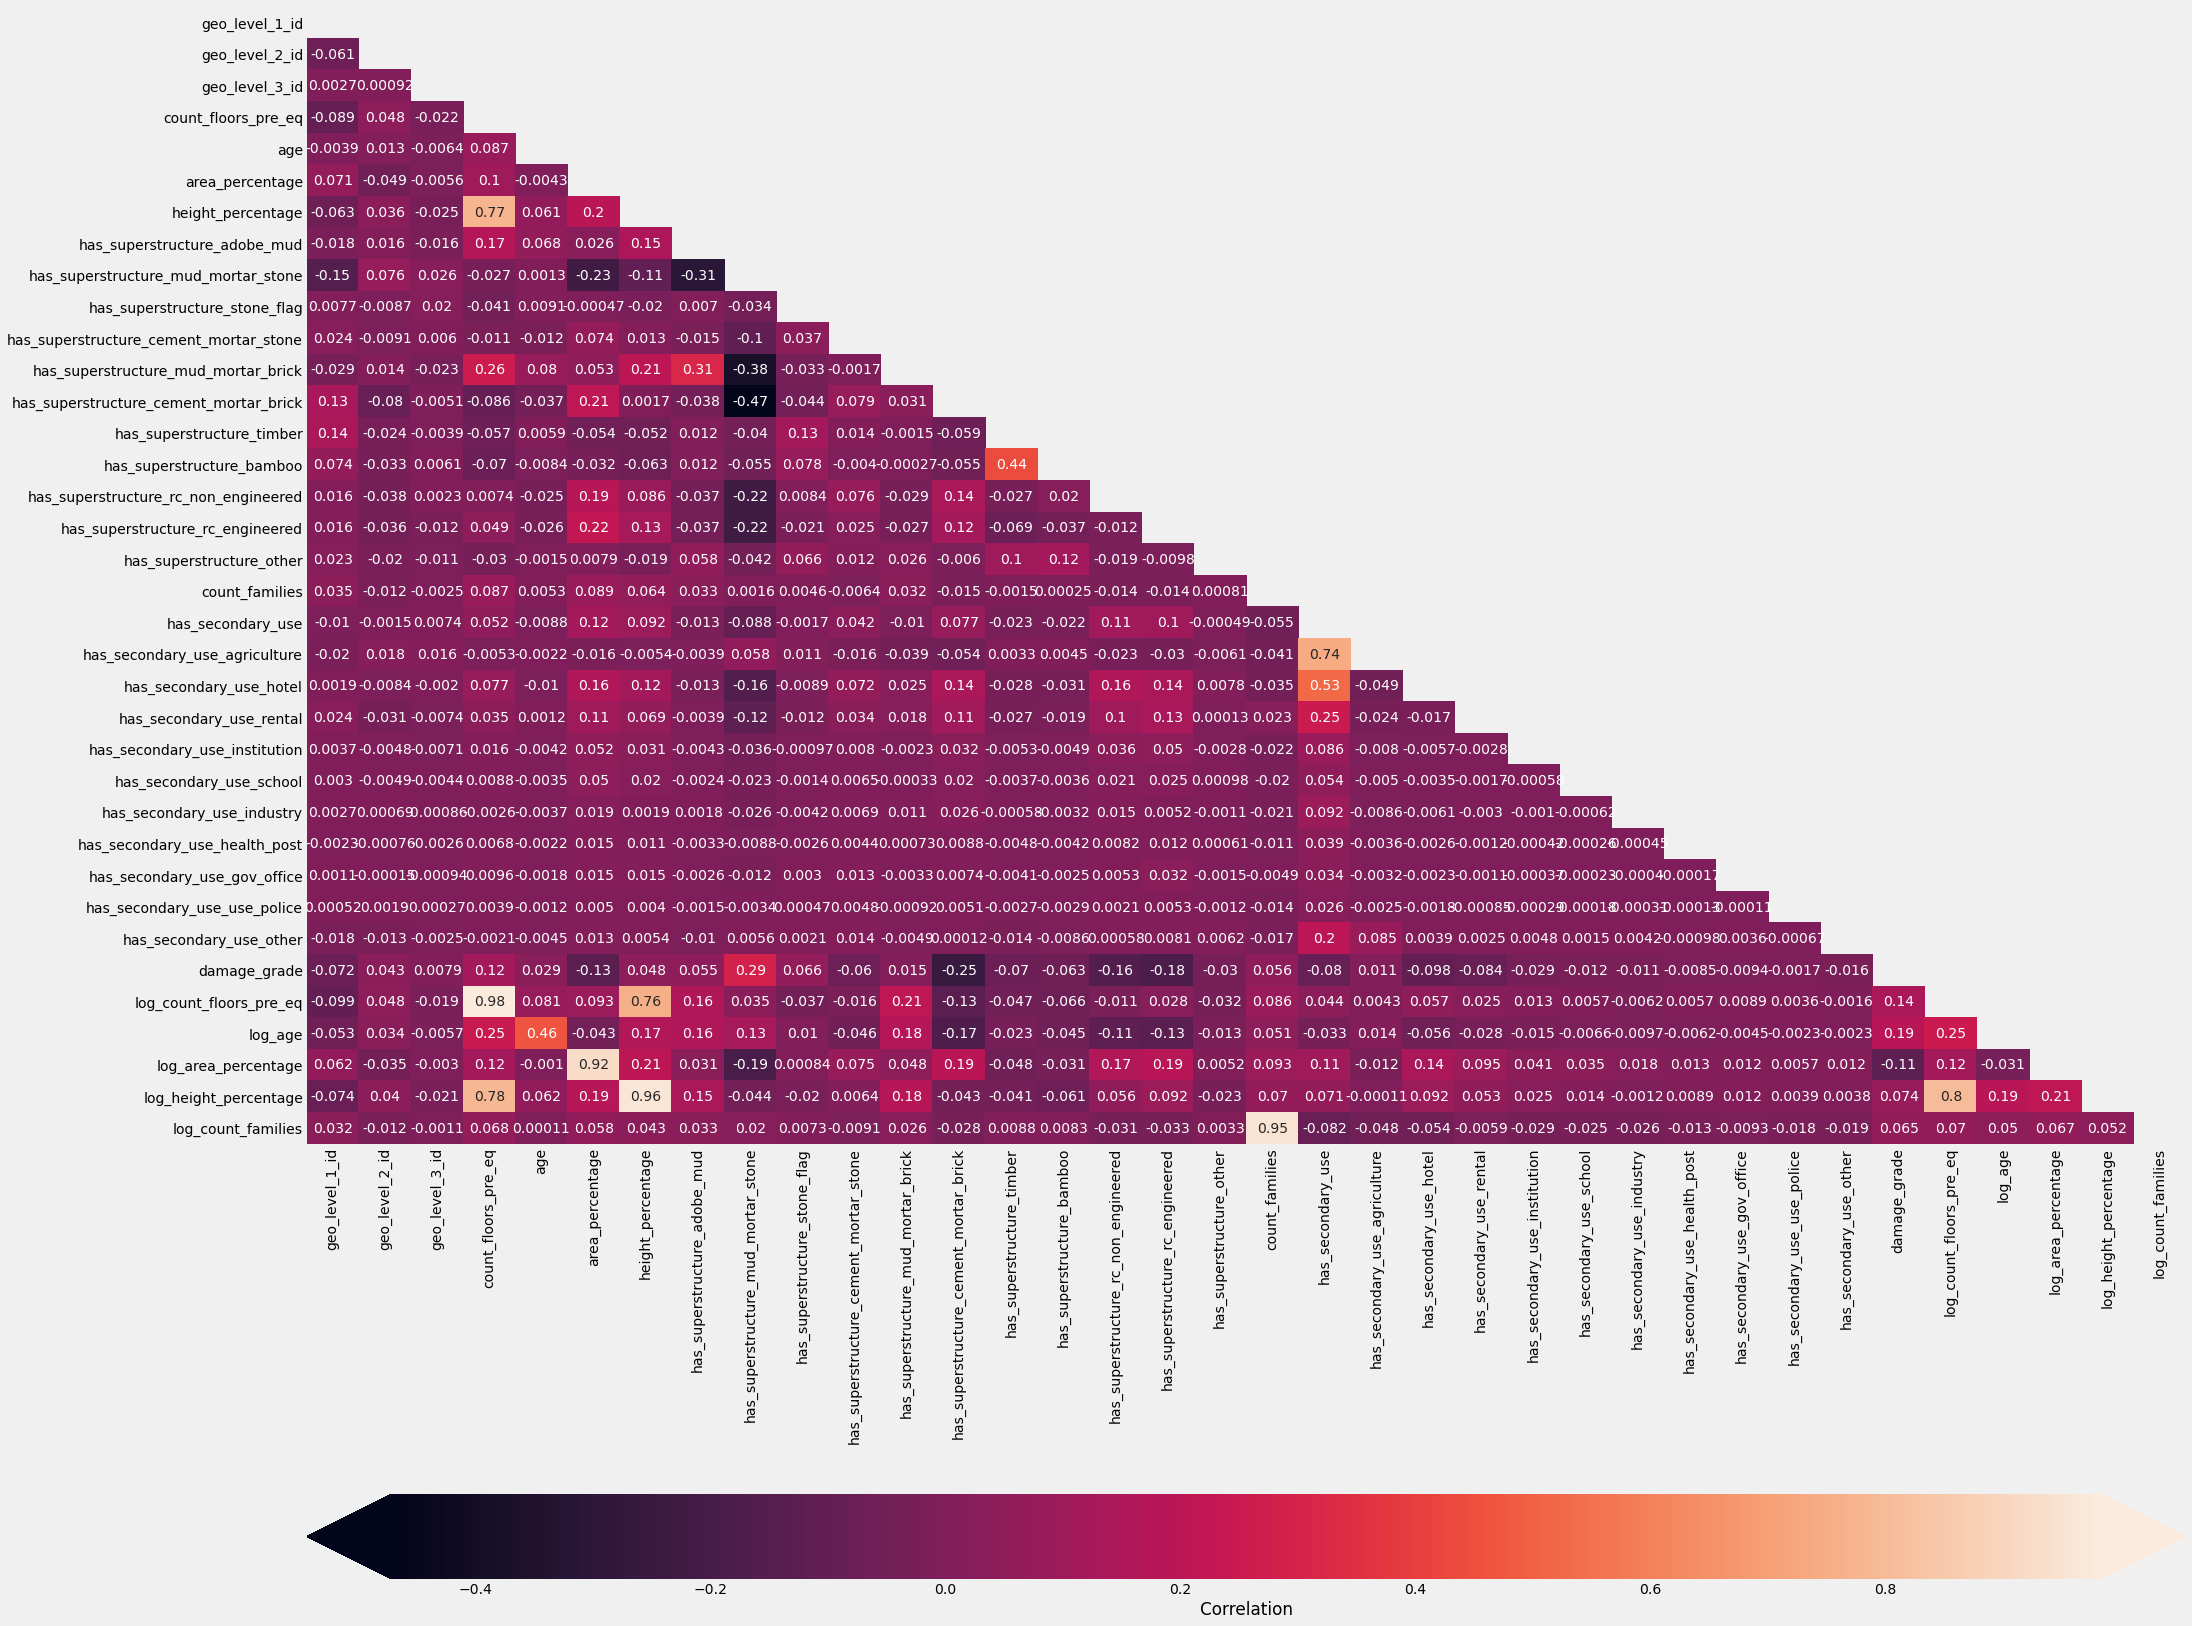

In [15]:
corr_matrix_mask = np.triu(np.ones_like(df.corr(), dtype=bool))
fig, ax = plt.subplots(figsize  =(30,30))
sns.heatmap(
            df.corr(), 
            ax=ax, 
            annot=True, 
            mask= corr_matrix_mask,
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

### Random Forest without feature engineering to check feature importances

In [24]:
X = df.drop(log_cols, axis=1).drop(['damage_grade', 'damage_label'], axis=1)
y = df.damage_grade

In [33]:
cat_cols

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status',
 'damage_label']

In [94]:
cat_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
transformer = ColumnTransformer([('categorical', cat_pipe, cat_cols)])

In [95]:
baseline_rf_pipe = imbPipeline([
    ('transformer', transformer),
    ('rf', RandomForestClassifier())
])
baseline_rf_pipe.fit(X, y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status'])])),
                ('rf', RandomForestClassifier())])

In [99]:
f1_micro = cross_val_score(baseline_rf_pipe, X, y, scoring='f1_micro')

In [102]:
f1_micro = f1_micro.mean()
f1_micro

0.5807345351111455

In [ ]:
baseline_rf